In [1]:
from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate
from qiskit.providers.jobstatus import JobStatus


import numpy as np
import matplotlib.pyplot as plt

In [52]:
from azure.quantum.qiskit import AzureQuantumProvider

#paste your Resource id here
resource_id = "/subscriptions/3ebb6852-5bbd-4d66-a93f-55303a44271e/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/PHYS576"

#Import your azure quantum provider resource_id
provider = AzureQuantumProvider (
    resource_id = resource_id,
    location = "westus"
)

from qiskit.providers.aer import QasmSimulator
qasm_backend = QasmSimulator()

sim_backend_qis = provider.get_backend('ionq.simulator', gateset='qis')
sim_backend_nat = provider.get_backend('ionq.simulator', gateset='native')

qpu_backend_qis = provider.get_backend('ionq.qpu', gateset='qis')
qpu_backend_nat = provider.get_backend('ionq.qpu', gateset='native')

In [11]:
from qiskit.providers.aer import QasmSimulator
qasm_backend = QasmSimulator()

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity

# NarrowBand(NB) composite pulse sequence
In the quantum signal processing's (QSP) point of view, composite pulses (CP) is a flexible tool to compensate systematic errors(i.g. the imperfection of the pulse length, pulse area or frequency offset). More generally, CP can shape the excitation profile in any way possible. In this section, the goal is to realize a narrowband composite pulses using IonQ's native gate sets. 

From the QSP the propagator $U$ can be represent as a *signal* rotation operator $W$ and a *signal processing* rotation $e^{i \phi_k Z}$:
\begin{equation}
    U = e^{i\phi_0 Z} \prod_{k=1}^{d} W(a) e^{i \phi_k Z} =R_z(\phi_0) U_{\phi_1}U_{\phi_2}U_{\phi_3} ...U_{\phi_N} =  R_z(\phi_0)\cdot R_x(\theta)R_z(\phi_1)\cdot R_x(\theta)R_z(\phi_2)... R_x(\theta)R_z(\phi_N), \tag{*}
\end{equation}
Where each $U_{\phi_N}$ can be consider as a $R_x(\theta)$ rotation followed by a $R_z$ rotations by a vector of angles $\phi$  . The Narrowband pulse sequence is using the result that is published [here](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.84.065404)[1]. We use the result that is derived by Kyoseva et al[1] to reconstruct the NB pulse sequence.


The notation that is used in [1] are as the following
\begin{equation}
U^{(N)} =U_{\phi_N} U_{\phi_{N-1}} .. U_{\phi_2}U_{\phi_1} 
\end{equation}
note that the order in [1] is in reverse order as the $(*)$ equation. Anyhow, the constructed NB composite pulse $\phi$ angles can be written as

\begin{align}
(\phi_1 , \phi_2 ... ,\phi_N) = & (0 ,\frac{2}{3}\pi, -\frac{2}{3}\pi ) &\text{ for } N=3 \\
&(0 ,\frac{2}{5}\pi, -\frac{2}{5}\pi, \frac{4}{5}\pi, -\frac{4}{5}\pi ) &\text{ for } N=5 \\
&(0 ,\frac{2}{7}\pi, -\frac{2}{7}\pi, \frac{4}{7}\pi, -\frac{4}{7}\pi, \frac{6}{7}\pi, -\frac{6}{7}\pi ) &\text{ for } N=7
\end{align}

With different order of shaping the excitation profile. We choose to demonstrate N=5 of NB in this section.

## Narrowband(NB) pulse sequence reconstructions using QIS gate set
First we try to reconstruct the NB pulse sequence using QIS gate sets ( i.e. $R_x(\theta)$ and $R_z(\phi)$ ). 

### QASM simulation
An important note: the QSP description uses a series of $Z$ operator exponentials.
This corresponds to a $Z$ rotation, however the precise angle of the rotation is not $\phi$ but actually $-2\phi$ due to the definition of the rotation operators. This change is important in following code.

In [37]:
def qsp_NB2(theta):
    
    circ = QuantumCircuit(1)
    
    #eta = np.arccos(-1/4) / 2
    phi = [0, np.pi*2/5, -np.pi*2/5, np.pi*4/5, -np.pi*4/5]

    # 5
    circ.rz(phi=-2*phi[0], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 4
    circ.rz(phi=-2*phi[1], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 3
    circ.rz(phi=-2*phi[2], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 2
    circ.rz(phi=-2*phi[3], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 1
    circ.rz(phi=-2*phi[4], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 0
    circ.rz(phi=-2*phi[0], qubit=0)
    
    circ.measure_all()

    return circ

def Rx_circ(theta):
    circ = QuantumCircuit(1)

    # R_x(theta)
    circ.rx(theta, qubit=0)
    
    # Measure the qubit
    circ.measure_all()
    
    return circ

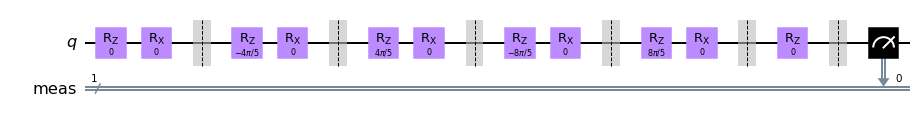

In [38]:
qsp_NB2(0).draw('mpl')

In [39]:
thetas = np.linspace(-np.pi, np.pi, 21)

In [40]:
qsp_circuits = []
rx_circuits = []

for theta in thetas:
    qsp_circuits.append( qsp_NB2(theta) )
    rx_circuits.append( Rx_circ(theta) )

In [41]:
def calc_p0(counts):
    
    try:
        counts['1']
    except:
        counts['1'] = 0
        
    try:
        counts['0']
    except:
        counts['0'] = 0
    
    total = counts['0'] + counts['1']
    return counts['0'] / total

In [42]:
qsp_p0s = []
for circuit in qsp_circuits:
    job = qasm_backend.run(circuit, shots=10000)
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

In [43]:
rx_p0s = []
for circuit in rx_circuits:
    job = qasm_backend.run(circuit, shots=10000)
    rx_p0s.append( calc_p0(job.result().get_counts()) )

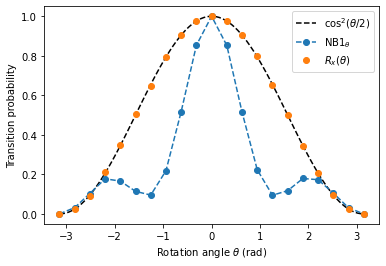

In [46]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')

plt.plot(thetas, qsp_p0s, 'o--', label=r'NB1$_\theta$')
plt.plot(thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

Here we see that indeed around $\theta$ at around 0, the composite pulses shapes the transition probability to a narrow band comparing to a $\sin^2(\theta)$ profile of a pure $R_x$ gate.

## IonQ native gate set on IonQ simulator.


We implement a general $R_x(\theta)$ rotation in the native gateset by the unitary

\begin{equation}
    R_x(\theta) = GPI_2(\phi=\pi/2) GZ(\theta) GPI_2^\dagger(\phi=\pi/2) = GPI_2(\phi=\pi/2) GZ(\theta) GPI_2(\phi=-\pi/2)
\end{equation}

Unfortunately, IonQ does not allow for direct usage of the $GZ(\theta) = R_z(\theta)$ gate in the circuit compilation and so we have to manually append the phase offset to all future gates, i.e.


\begin{equation}
    R_x(\theta) \equiv GPI_2(\phi=\pi/2 + \theta) GPI_2(\phi=-\pi/2).
\end{equation}

Note that this requires that **all** subsequent gates are phase shifted by $\theta$.

In [47]:
from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate
from qiskit.providers.jobstatus import JobStatus


import numpy as np
import matplotlib.pyplot as plt

In [48]:
def qsp_NB_native(theta):
    
    circ = QuantumCircuit(1)
    
    phi = [0, np.pi*2/5, -np.pi*2/5, np.pi*4/5, -np.pi*4/5]

    # 5
    delay = -2*phi[0]/(2*np.pi)
    # R_x(theta)
    # The RZ phase shift is incorporated by the delay term
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 4
    # The new delay increases by the new phi and theta from previous gates
    delay += -2*phi[1]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 3
    delay += -2*phi[2]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 2
    delay += -2*phi[3]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 1
    delay += -2*phi[4]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    # 0
    # circ.rz(phi=-2*phi[0], qubit=0)
    # We're supposed to have an Rz here but since it does not affect
    # the probabilities we just ignore it since we cannot implement it
    # using the IonQ system's current toolset.
    
    circ.measure_all()

    return circ

def Rx_circ_native(theta):
    circ = QuantumCircuit(1)

    # R_x(theta)
    circ.append(GPI2Gate(-0.25),[0]) 
    circ.append(GPI2Gate(0.25 + theta),[0]) 
    
    # Measure the qubit
    circ.measure_all()
    
    return circ

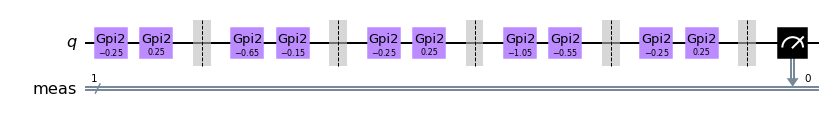

In [49]:
qsp_NB_native(0).draw('mpl')

In [50]:
# Need to modify to fractional rotations from radians for the native set
thetas = np.linspace(-0.5, 0.5, 11)

qsp_circuits = []
rx_circuits = []

for theta in thetas:
    qsp_circuits.append( qsp_NB_native(theta) )
    rx_circuits.append( Rx_circ_native(theta) )

In [53]:
qsp_p0s = []
for circuit in qsp_circuits:
    job = sim_backend_nat.run(circuit, shots=10000)
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

.............................................................................

In [54]:
rx_p0s = []
for circuit in rx_circuits:
    job = sim_backend_nat.run(circuit, shots=10000)
    rx_p0s.append( calc_p0(job.result().get_counts()) )

.................................................................................

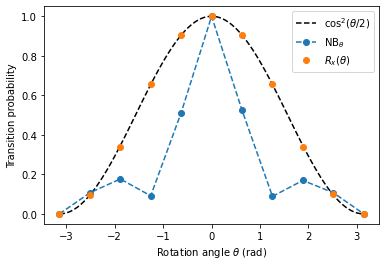

In [57]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')

plt.plot(2*np.pi*thetas, qsp_p0s, 'o--', label=r'NB$_\theta$')
plt.plot(2*np.pi*thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

The result fits our expectation on `ionq.simulator`. 

## IonQ QPU
Now we try to run the circuit on real qpu. `Aria-1` seems to have a smaller queue time.

The jobs were submitted on Sunday Jan 22, 2023.  

In [59]:
qpu_aria1_nat = provider.get_backend('ionq.qpu.aria-1', gateset='native')

In [60]:
'''qsp_jobs = []
print('Running jobs for the QSP circuits...')
for circuit in qsp_circuits:
    job = qpu_aria1_nat.run(circuit, shots=1000)
    print('Job ID:', job.job_id())'''

Running jobs for the QSP circuits...
Job ID: 3905086e-9a80-11ed-9175-2a2779b1dac2
Job ID: 3a1526d0-9a80-11ed-9175-2a2779b1dac2
Job ID: 3ac352c8-9a80-11ed-9175-2a2779b1dac2
Job ID: 3b734264-9a80-11ed-9175-2a2779b1dac2
Job ID: 3c25b3f4-9a80-11ed-9175-2a2779b1dac2
Job ID: 3cd731a6-9a80-11ed-9175-2a2779b1dac2
Job ID: 3d84f62e-9a80-11ed-9175-2a2779b1dac2
Job ID: 3e397338-9a80-11ed-9175-2a2779b1dac2
Job ID: 3ee70bba-9a80-11ed-9175-2a2779b1dac2
Job ID: 3f9e33a8-9a80-11ed-9175-2a2779b1dac2
Job ID: 406ad5d4-9a80-11ed-9175-2a2779b1dac2


Rerun the circuits on Aria-1

    Job ID: 3905086e-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3a1526d0-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3ac352c8-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3b734264-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3c25b3f4-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3cd731a6-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3d84f62e-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3e397338-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3ee70bba-9a80-11ed-9175-2a2779b1dac2
    Job ID: 3f9e33a8-9a80-11ed-9175-2a2779b1dac2
    Job ID: 406ad5d4-9a80-11ed-9175-2a2779b1dac2

In [65]:
qsp_jobs_retrieved = [qpu_backend_nat.retrieve_job('3905086e-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3a1526d0-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3ac352c8-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3b734264-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3c25b3f4-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3cd731a6-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3d84f62e-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3e397338-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3ee70bba-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('3f9e33a8-9a80-11ed-9175-2a2779b1dac2'),
                      qpu_backend_nat.retrieve_job('406ad5d4-9a80-11ed-9175-2a2779b1dac2')
                     ] 

print('QSP Jobs are done?')
for job in qsp_jobs_retrieved:
    print(job.done())

QSP Jobs are done?
False
False
False
False
False
False
False
False
False
False
False


In [61]:
rx_jobs = []
print('Running jobs for the Rx circuits...')
for circuit in rx_circuits:
    job = qpu_aria1_nat.run(circuit, shots=1000)
    print('Job ID:', job.job_id())

Running jobs for the Rx circuits...
Job ID: 2513ba34-9a81-11ed-9175-2a2779b1dac2
Job ID: 26687afa-9a81-11ed-9175-2a2779b1dac2
Job ID: 2713fbbe-9a81-11ed-9175-2a2779b1dac2
Job ID: 27c69828-9a81-11ed-9175-2a2779b1dac2
Job ID: 287cc9cc-9a81-11ed-9175-2a2779b1dac2
Job ID: 292f939a-9a81-11ed-9175-2a2779b1dac2
Job ID: 29df9a2e-9a81-11ed-9175-2a2779b1dac2
Job ID: 2a8fcfd4-9a81-11ed-9175-2a2779b1dac2
Job ID: 2b423732-9a81-11ed-9175-2a2779b1dac2
Job ID: 2bfa5c72-9a81-11ed-9175-2a2779b1dac2
Job ID: 2cc64d28-9a81-11ed-9175-2a2779b1dac2


$R_x$ jobs' ID

    Job ID: 2513ba34-9a81-11ed-9175-2a2779b1dac2
    Job ID: 26687afa-9a81-11ed-9175-2a2779b1dac2
    Job ID: 2713fbbe-9a81-11ed-9175-2a2779b1dac2
    Job ID: 27c69828-9a81-11ed-9175-2a2779b1dac2
    Job ID: 287cc9cc-9a81-11ed-9175-2a2779b1dac2
    Job ID: 292f939a-9a81-11ed-9175-2a2779b1dac2
    Job ID: 29df9a2e-9a81-11ed-9175-2a2779b1dac2
    Job ID: 2a8fcfd4-9a81-11ed-9175-2a2779b1dac2
    Job ID: 2b423732-9a81-11ed-9175-2a2779b1dac2
    Job ID: 2bfa5c72-9a81-11ed-9175-2a2779b1dac2
    Job ID: 2cc64d28-9a81-11ed-9175-2a2779b1dac2

In [ ]:
rx_jobs_retrieved = [qpu_backend_nat.retrieve_job('2513ba34-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('26687afa-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('2713fbbe-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('27c69828-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('287cc9cc-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('292f939a-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('29df9a2e-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('2a8fcfd4-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('2b423732-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('2bfa5c72-9a81-11ed-9175-2a2779b1dac2'),
                     qpu_backend_nat.retrieve_job('2cc64d28-9a81-11ed-9175-2a2779b1dac2')
                    ] 

print('Rx Jobs are done?')
for job in rx_jobs_retrieved:
    print(job.done())

In [ ]:
qsp_p0s = []
for job in qsp_jobs_retrieved:
    print(job.result().get_counts())
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

In [ ]:
rx_p0s = []
for job in rx_jobs_retrieved:
    print(job.result().get_counts())
    rx_p0s.append( calc_p0(job.result().get_counts()) )

In [ ]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')


plt.plot(2*np.pi*thetas, qsp_p0s, 'o--', label=r'BB1$_\theta$')
plt.plot(2*np.pi*thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

# Broadband(BB) composite pulse sequence

Although BB1 may not serve as a means of counteracting error in the currently available NISQ systems, there is potential for BB1 to have significance in other aspects, such as modifying the parameter sensitivity as discussed in [2]. Such modification of the transition probability bears some significance to generalizations of quantum algorithms.

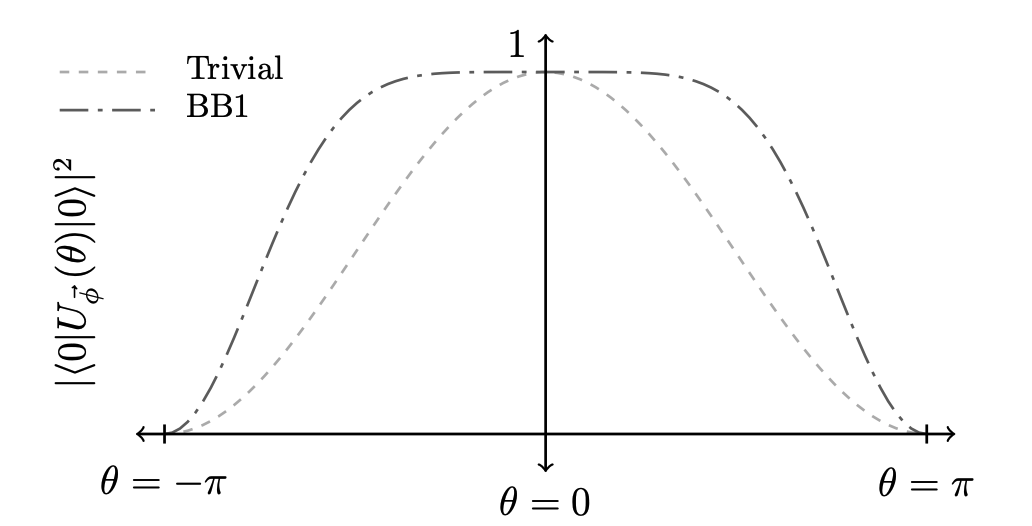

Following the discussion in [2], the BB1 sequence (and indeed general QSP sequences) can be represented as a sequence of operations:

\begin{equation}
    U = e^{i\phi_0 Z} \prod_{k=1}^{d} W(a) e^{i \phi_k Z},
\end{equation}

i.e. a series of interleaved $R_z$ rotations by a vector of angles $\phi$ and a single operator $W(a)$.
To not stray too far from what has already been discussed, we note that the rotation operator $W(a)$ is can be taken to be an $x$-rotation operator by angle $\theta = -2\cos^{-1}a$.
In otherwords we can let $W(a) = R_x(-2\cos^{-1}a)$ --- since we want to parameterize in terms of $\theta$ anyway it is fine to ignore the $a$ variable for this work.

As given by [2], the set of phases $\phi = (\pi/2, -\eta, 2\eta, 0, -2\eta, \eta)$ with $\eta = \cos^{-1}(-1/4) / 2$ gives the BB1 sequence.
This is different from the above BB1 consider in the previous parts.
We do not fully understand the distinction between these two sequences.

Let us attempt to implement the sequence using the simulators first:

## QASM simulator

## IonQ simulator

## IonQ qpu

# PB Sequence 

1. implement on QASM using RxRz 
2. translate into IonQ native gates
3. run on QPU